In [1]:
####Imports and Setup
import os
import sys
import time
import glob
import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import patsy
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
###########################
import numpy as np
import scipy 
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
# We are using the BernoulliNB version of Naive Bayes, which assumes predictors are binary encoded.
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import cross_val_score, train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/Users/DavisJohnson/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
##### Definitions

def strtimedelta(starttime, stoptime):
    return str(datetime.timedelta(seconds=stoptime-starttime))

def apply_to_all_files(basedir, func=lambda x: x, ext='.h5'):
    cnt = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root, '*'+ext))
        cnt += len(files)
        for f in files:
            func(f)
    return cnt

def func_to_get_artist_name(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    artist_name = GETTERS.get_artist_name(h5)
    all_artist_names.add(artist_name)
    h5.close()

def func_to_count_artist_id(filename):
    h5 = GETTERS.open_h5_file_read(filename)
    artist_id = GETTERS.get_artist_id(h5)
    files_per_artist[artist_id] += 1
    h5.close()   
    

def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

def update_columns(col_names, label):
    new_names = []
    new_names.append(col_names[0])
    for name in col_names[1:]:
        name = label + name
        new_names.append(name)
    return new_names

def is_ascii(column):
    column_list = []
    for col in column:
        for letter in col:
            if ord(letter) > 128:
                column_list.append(col)
                continue
    return column_list

In [4]:
conn_addf_metadata = sqlite3.connect('../../Capstone/MillionSongSubset/AdditionalFiles/subset_track_metadata.db')
conn_addf_art_term = sqlite3.connect('../../Capstone/MillionSongSubset/AdditionalFiles/subset_artist_term.db')

In [148]:
df_metadata_songs = pd.read_sql("SELECT * FROM songs", con=conn_addf_metadata)
df_term_artist_mbtag = pd.read_sql("SELECT * FROM artist_mbtag", con=conn_addf_art_term)
df_term_artist_term = pd.read_sql("SELECT * FROM artist_term", con=conn_addf_art_term)

In [149]:
df_term_artist_mbtag.head()

,artist_id,mbtag
0,AR00A6H1187FB5402A,detroit
1,AR00A6H1187FB5402A,punk
2,AR00A6H1187FB5402A,michigan
3,AR00A6H1187FB5402A,usa
4,AR01VU31187B997DA0,hard rock


In [150]:
df_term_artist_mbtag.shape

(3809, 2)

In [151]:
###Convert the tag dataframe into its wide format and display the count of genres
###from the mbtag resource (based on artist_id)
df_term_artist_mbtag['values'] = 1
df_term_artist_mbtag_wide = df_term_artist_mbtag.pivot_table(index='artist_id', 
                                          columns='mbtag', 
                                          values='values',
                                          fill_value=0).reset_index()

In [152]:
df_term_artist_mbtag_wide.head()

mbtag,artist_id,00s,1 13 165900 150 7672 22647 34612 48720 59280 74602 87545 95495 107182 131087 141522 153710,1 7 186240 183 23558 41608 89158 111733 150833 169883,10s,1960s,1970s,1980s,1990s,2000s,...,wp musicians,wu-tang,x,yé-yé,zouk,zydeco,éire,ਪੰਜਾਬੀ,ਭੰਗੜਾ,香港歌手
0,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AR01VU31187B997DA0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR01W2D1187FB5912F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR022JO1187B99587B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR02IU11187FB513F2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
df_term_artist_mbtag_wide.shape

(1091, 727)

In [154]:
df_mbtag_values = df_term_artist_mbtag.groupby('mbtag').agg({'values':np.sum}).sort_values(by='values', ascending=False).reset_index()

In [155]:
df_mbtag_values.head()

,mbtag,values
0,american,192
1,classic pop and rock,171
2,rock,166
3,british,122
4,rock and indie,119


In [156]:
df_mbtag_values.describe()

,values
count,726.000000
mean,5.246556
std,16.038697
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,192.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b61a410>]], dtype=object)

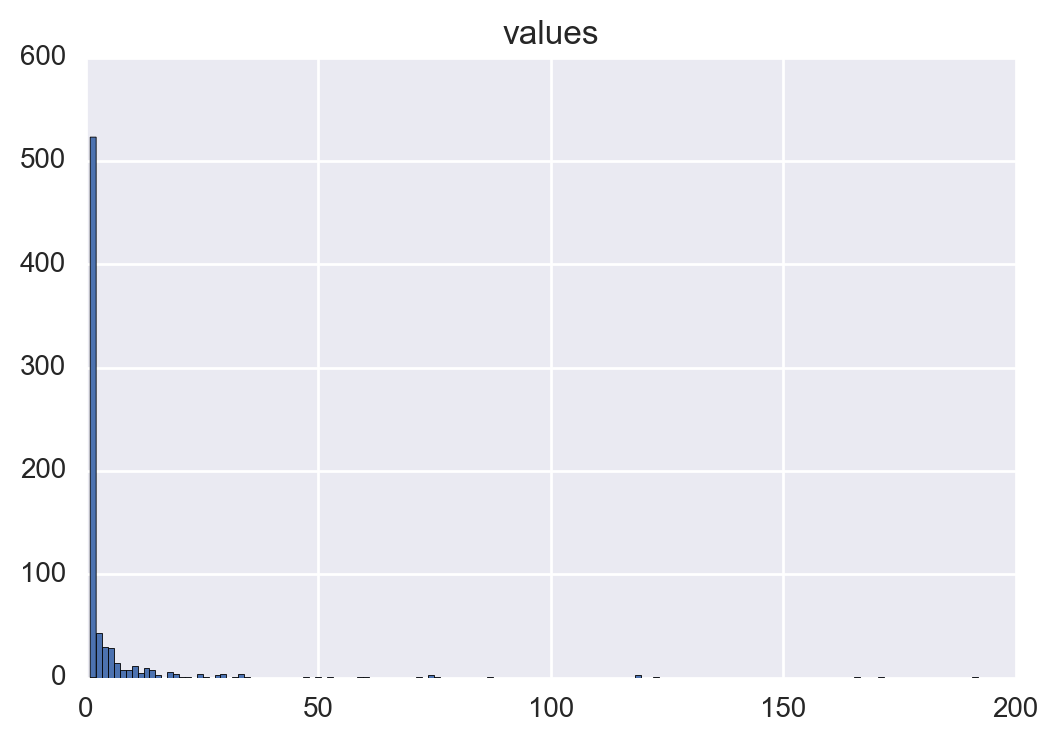

In [157]:
df_mbtag_values.hist(bins=150)

In [161]:
###Take the middle 50% of the column values (one standard deviation from the mean) - in order
###to pick features that are more unique across the various artists
cols = list(df_term_artist_mbtag_wide.columns.values)
cols_use, cols_del = [], []
for x in cols:
    if (df_term_artist_mbtag_wide[x].sum() >= 3 and df_term_artist_mbtag_wide[x].sum() <= 7) or x == 'artist_id':
        cols_use.append(x)
    else:
        cols_del.append(x)

In [162]:
len(cols_use)

117

In [163]:
###Drop the unwanted columns from the table (that had less than 8)

##I chose the number "8" here because I want to remove any noise from the data set
##I need to make sure that all the information available is relevant and dosen't represent
##an artist or a song already. For example, "Weezer" is represented once already and would
##be a strong indicator of genre or artist...so want to remove the noise.
## I want indicators that are relevant across various artists and genres, that is why chossing
## above a certain number is helpful
df_term_artist_mbtag_wide = df_term_artist_mbtag_wide.drop(cols_del, axis=1)

In [164]:
df_term_artist_mbtag_wide.head()

mbtag,artist_id,00s,60s,acid rock,adult contemporary,alternative dance,alternative hip-hop,argentina,art punk,australia,...,sludge metal,southern rock,spanish,swing,synthpop,thrash metal,trance,turkish,video game,warp
0,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AR01VU31187B997DA0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR01W2D1187FB5912F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR022JO1187B99587B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR02IU11187FB513F2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
df_term_artist_mbtag_wide.shape

(1091, 117)

In [166]:
df_term_artist_mbtag_wide.columns = update_columns(df_term_artist_mbtag_wide.columns, 'mbtag_')

In [167]:
##Get the tag data set into a format with valuable information to
##combine with other data (uniquely identify the titles so I know which tags are which)
df_term_artist_mbtag_wide.head()

,artist_id,mbtag_00s,mbtag_60s,mbtag_acid rock,mbtag_adult contemporary,mbtag_alternative dance,mbtag_alternative hip-hop,mbtag_argentina,mbtag_art punk,mbtag_australia,...,mbtag_sludge metal,mbtag_southern rock,mbtag_spanish,mbtag_swing,mbtag_synthpop,mbtag_thrash metal,mbtag_trance,mbtag_turkish,mbtag_video game,mbtag_warp
0,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AR01VU31187B997DA0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR01W2D1187FB5912F,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR022JO1187B99587B,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR02IU11187FB513F2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
df_term_artist_mbtag_wide.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)

In [169]:
df_term_artist_mbtag_wide.to_csv('df_term_artist_mbtag_wide.csv', encoding='utf-8')

In [170]:
df_term_artist_term.head()

,artist_id,term
0,AR009211187B989185,lovers rock
1,AR009211187B989185,reggae
2,AR009211187B989185,roots reggae
3,AR009211187B989185,uk garage
4,AR009211187B989185,ballad


In [171]:
df_term_artist_term.shape

(97493, 2)

In [172]:
###Convert the term dataframe into its wide format and show the sum of the 
df_term_artist_term['values'] = 1
df_term_artist_term_wide = df_term_artist_term.pivot_table(index='artist_id',
                                                     columns='term',
                                                     values='values',
                                                     fill_value=0).reset_index()

In [173]:
df_term_artist_term_wide.head()

term,artist_id,00s,00s country,00s pop,1800s,1910s,1960s soul,1970s soul,19th century,19th century classical,...,zaire,zairean,zimbabwe,zommetal,zouk,zouklove,zxzw,zxzw 2006,zxzw 2008,zydeco
0,AR009211187B989185,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR00LNI1187FB444A5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR00MBZ1187B9B5DB1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR01IP11187B9AF5D2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
df_term_artist_term_wide.shape

(3885, 3503)

In [175]:
df_term_values = df_term_artist_term.groupby('term').agg({'values':np.sum}).sort_values(by='values', ascending=False).reset_index()

In [176]:
df_term_values.head()

,term,values
0,rock,2346
1,pop,1876
2,electronic,1709
3,jazz,1239
4,united states,1184


In [177]:
df_term_values.describe()

,values
count,3502.000000
mean,27.839235
std,105.818209
min,1.000000
25%,1.000000
50%,3.000000
75%,11.000000
max,2346.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11be47550>]], dtype=object)

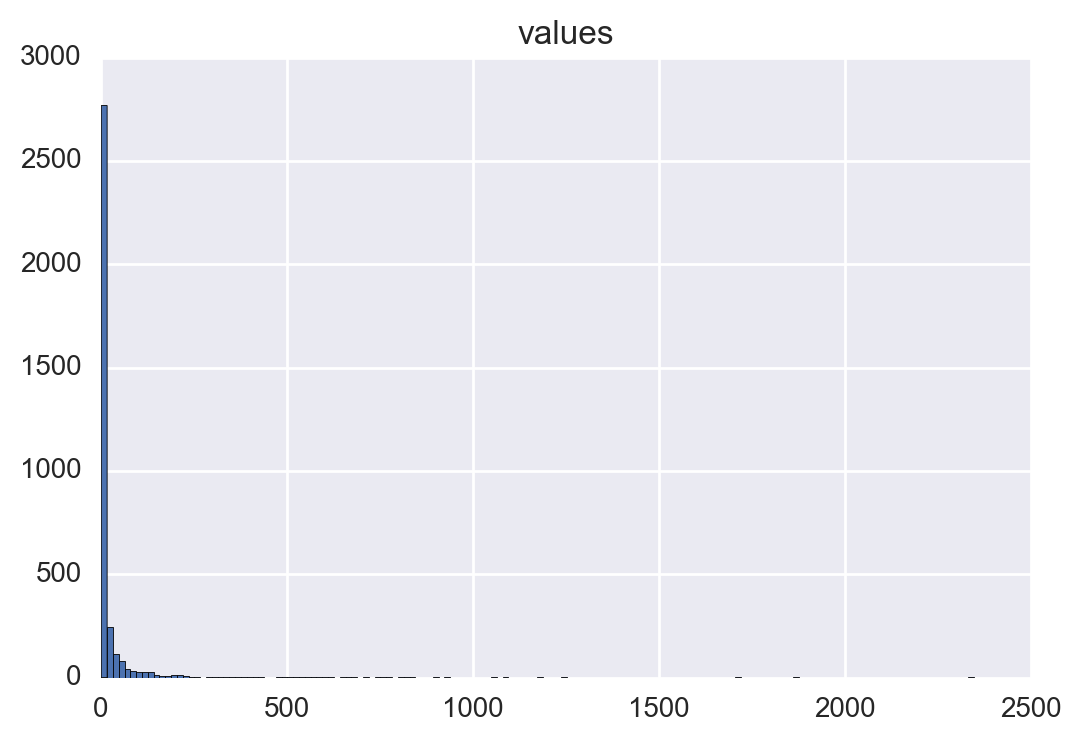

In [178]:
df_term_values.hist(bins=150)

In [183]:
###Took only the summation of the terms that were around the mean and then
###roughly a half standard deveation from the mean. Dwindled it down and rounded for this
###dataset because it had a lot more features from the beginning, so trying to reduce as
###much possible noise in the pre-processing phase
cols = list(df_term_artist_term_wide.columns.values)
cols_use, cols_del = [], []
for x in cols:
    if (df_term_artist_term_wide[x].sum() >= 24 and df_term_artist_term_wide[x].sum() <= 30) or x == 'artist_id':
        cols_use.append(x)
    else:
        cols_del.append(x)

In [184]:
len(cols_use)

95

In [185]:
df_term_artist_term_wide = df_term_artist_term_wide.drop(cols_del, axis=1)

In [186]:
df_term_artist_term_wide.head()

term,artist_id,20th century,30s,alternative dance,arena rock,banjo,bhangra,british blues,british invasion,british punk rock,...,taiwan,technical,traditional folk,traditional pop,twee pop,uk,virtuoso,vocal house,western,zouk
0,AR009211187B989185,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR00LNI1187FB444A5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR00MBZ1187B9B5DB1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR01IP11187B9AF5D2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
df_term_artist_term_wide.shape

(3885, 95)

In [188]:
df_term_artist_term_wide.columns = update_columns(df_term_artist_term_wide.columns, 'term_')

In [189]:
df_term_artist_term_wide.head()

,artist_id,term_20th century,term_30s,term_alternative dance,term_arena rock,term_banjo,term_bhangra,term_british blues,term_british invasion,term_british punk rock,...,term_taiwan,term_technical,term_traditional folk,term_traditional pop,term_twee pop,term_uk,term_virtuoso,term_vocal house,term_western,term_zouk
0,AR009211187B989185,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AR00A6H1187FB5402A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AR00LNI1187FB444A5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AR00MBZ1187B9B5DB1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AR01IP11187B9AF5D2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [190]:
df_term_artist_term_wide.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)

In [191]:
df_term_artist_term_wide.to_csv('df_term_artist_term_wide.csv', encoding='utf-8')

In [192]:
###All sub-genre dataframe
df_sub_genre = pd.merge(df_term_artist_mbtag_wide, df_term_artist_term_wide, how='inner', on='artist_id')

In [195]:
df_sub_genre.to_csv('df_sub_genre.csv', encoding='utf-8')

In [196]:
###Combine to song_meta data
df_sub_genre_metadata = pd.merge(df_metadata_songs, df_sub_genre, how='inner', on='artist_id')

In [197]:
df_sub_genre_metadata.to_csv('df_sub_genre_metadata.csv', encoding='utf-8')